# The "Slump" Predictor

We look to define, identify, and predict the expected length of a "slump" for a given player in a given year. First, let's get some data. The data will be gathered for a previously obtained list of active players (players.csv)

(data is now collected and cleaned, skip to 'Import clean data')

In [56]:
import pandas as pd

# List of active players with baseball-reference id
master = pd.read_csv('players.csv', encoding='unicode_escape')

# Filter out pitchers
for index, row in master.iterrows():
    if row['mlb_pos'] == 'P':
        master.drop(index, inplace=True)

# Keep only playerID
active = []
for index, row in master.iterrows():
    if pd.isnull(row['bref_id']):
        continue
    else:
        active.append(row['bref_id'])

print('done')

done


Now we get the gamelog info for each active player from baseball-reference.com

In [57]:
import collections as co
import time
import requests
from bs4 import BeautifulSoup

# Create master dataframe
log = pd.DataFrame()

# Crawl through active players on baseball-reference
for playerID in active:
    # Catch if no data for 2017
    try:
        # Get gamelog stat table
        url = 'https://www.baseball-reference.com/players/gl.fcgi?id='+str(playerID)+'&t=b&year=2017'
        page = requests.get(url)
        soup = BeautifulSoup(page.text, 'html.parser')
        stat_table = soup.find(lambda tag:
                               tag.name == 'table' and
                               tag.has_attr('id') and
                               tag['id'] == "batting_gamelogs") 

        # Define attributes
        table_body = stat_table.find('tbody')
        table_head = stat_table.find('thead')
        header = []    
        for th in table_head.findAll('th'):
            key = th.get_text()
            header.append(key)

        # loop over table to find number of rows with '' in first column
        endrows = 0
        for tr in stat_table.findAll('tr'):
            if tr.findAll('th')[0].get_text() in '':
                endrows += 1

        rows = len(stat_table.findAll('tr'))
        
        # Get rid of totals
        rows -= endrows

        # Turn into dict for df
        list_of_dicts = []
        for row in range(rows):
            the_row = []
            try:
                table_row = stat_table.findAll('tr')[row]
                for tr in table_row:
                    value = tr.get_text()
                    the_row.append(value)
                od = co.OrderedDict(zip(header,the_row))
                list_of_dicts.append(od)
            except AttributeError:
                continue 

        # Define df and create initial column with playerID
        player = pd.DataFrame(list_of_dicts)
        player['playerID'] = playerID

        # Append player to master
        log = pd.concat([log, player])

        # Add 1s wait to slow down bbref crawl
        time.sleep(1)
        
    except:
        continue

print('done')

done


With the data gathered, we now clean the data.

Major takeaways: Data, team, and position are encoded. Home vs. Away have been separated, run differential is added, and a colun is added to keep track of the number of innings played

In [54]:
# Copy df
data = log.copy()

# Encode date as number
# Dict to convert date to length into season
month = {'Apr':0,'May':30,'Jun':61,'Jul':91,'Aug':122,'Sep':153,'Oct':183}

# Split into month and day
df3 = data['Date'].str.split(' ', expand=True)
# Convert month to number
df3[0] = df3[0].map(month)

# Find and drop nan
idx = df3.index[df3.isnull().all(1)]
nans = df3.ix[idx]
df3 = df3.drop(df3.index[idx])
data = data.drop(data.index[idx])

# Add month + day to get length into season
df3[1] = df3[1].str.extract('(\d+)').astype(int)
data['Date'] = df3[0] + df3[1]

# Rename @ column
data.rename(columns={data.columns[6]: 'HvA'}, inplace=True)
# Change @ to be boolean
mask = (data['HvA'].isnull())
data['HvA'] = np.where(mask,1,0)

# Fix up innings to be just a number
data['Inngs'].loc[data['Inngs'] == 'CG'] = '-9'
# Split into new df for processing
df1 = data['Inngs'].str.split('-', expand=True)
df1[1].fillna('1', inplace=True)
df1[0].loc[df1[0] == 'GS'] = '1'
df1[1].loc[df1[1] == 'GF'] = '9'
df1[0].loc[df1[0] == ''] = '1'
df1[0].fillna('1', inplace=True)
df1[0] = df1[0].str.extract('(\d+)').astype(int)
df1[1] = df1[1].str.extract('(\d+)').astype(int)
# Now redefine original df
data['Inngs'] = abs(df1[1] - df1[0]) + 1

# Split results into W/L, and run-diff
# Redifine W/L as boolean
mask = (data['Rslt'].str.contains('W'))
data['W/L'] = np.where(mask, 1,0)
# Extract scores
df2 = data['Rslt'].str.split('-', expand=True)
df2.fillna('0', inplace=True)  # filter nan
df2[0] = df2[0].str.extract('(\d+)').astype(int)
df2[1] = df2[1].str.extract('(\d+)').astype(int)
# Redefine runDiff
data['Rslt'] = df2[0] - df2[1]
# Rename results to be runDiff
data.rename(columns={'Rslt': 'runDiff'}, inplace=True)

# Split Gtm into Gtm and Gmiss
df4 = data['Gtm'].str.split('\(', expand=True)
df4.fillna('0', inplace=True)  # filter nan
df4[0] = df4[0].str.extract('(\d+)').astype(int)
df4[1] = df4[1].str.extract('(\d+)').astype(int)
data['Gtm'] = df4[0]
data['Gmiss'] = df4[1]

# Normalize data before one-hot
# Columns to be min/max standardized
mcols = ['Rk','Gcar','Gtm','Date','runDiff','Inngs','PA','AB','R','H','2B','3B','HR','RBI',
         'BB','IBB','SO','HBP','SH','SF','ROE','GDP','SB','CS','BA','OBP','SLG','OPS','BOP',
         'aLI','WPA','RE24','DFS(DK)','DFS(FD)','Gmiss']
# Now for the min/max transform
for col in mcols:
    data[col] = data[col]/data[col].max()

# One-hot encode team(Tm), opponent(Opp), position(Pos)
# Make sure not to encode playerID, we will need that later
col = ['Tm','Opp','Pos']
data = pd.get_dummies(data,prefix=col,columns=col)

# Drop column 1, redundant
data = data.drop(data.columns[0],axis=1)

# Save clean data
data.to_csv('clean_data.csv')

print(data.shape, '\n', 'done')

(50105, 236) 
 done


# Import clean data

We now refer to the saved csv for future work. This way we do not have to further query baseball reference for our data

In [26]:
# With the data cleaned, we now can start with the clean csv
import pandas as pd
import numpy as np

clean = pd.read_csv('clean_data.csv', encoding='unicode_escape')

print(clean.shape)

(50105, 237)


Now to define a slump. We are usinng OBP as the defining stat as OBP is more telling of overall batting performance than AVG, and the use of a single stat adds simplicity without much of an effect on overall accuracy.

To see what drop in OBP should define a slump, we look at the data for the season

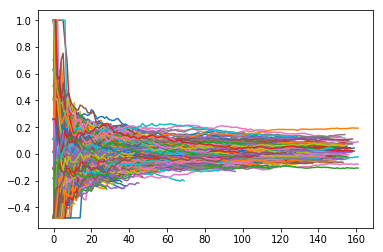

In [38]:
import matplotlib.pyplot as plt

# We will split the master df into a dictionary of dfs separated by playerID
dfs = dict(tuple(clean.groupby('playerID',as_index=False)))

for player, stats in dfs.items():
    stats = stats.drop(columns='Unnamed: 0').reset_index(drop=True)
    plt.plot(stats.index.values, stats['OBP'])
    
plt.show()

As expected, varience in OBP is extremely high at the start of the season, and starts to stabilize around game 10-20.

To account for this, we will look at a 10 game moving average of OBP, this should also take into account a few different series, which would account for anomolies in performance against a specific team.

Our marker of a slump will be approximately a 10% drop in performace. To make sure we take into account the start of season varience, this will be defined as 1/3 of a standard deviation

In [39]:
# Now go through each player and add a new boolean column to say if player is in a slump
# Look at OBP 10 game moving average (should take into account 2-3 series)
# This column will be used to test our accuracy
for player, stats in dfs.items():
    # Add column for slump
    stats['slump'] = 0
    
    # Slump definition using OBP
    Avg = stats['OBP'].mean()
    # rollAvg = stats['OBP'].rolling(10).mean()
    # Slump if falls 1/3 StDev (~10%)
    StDev = Avg - (stats['OBP'].std()/3)
    i=0
    for game in stats['OBP']:  # rollAvg:
        if game < StDev:
            stats.loc[i, 'slump'] = 1
        i += 1
    
    # Get second slump column with length of slump, this is our Y data
    stats['sLen'] = 0
    sLen = 0
    n = len(stats['slump'])
    i = 0
    for game in stats['slump'].values:
        # Continue until a slump is found
        if game == 0:
            if sLen == 0:
                i += 1
        # If slump ends before season ends, continue
            else:
                stats.loc[(i+1)-sLen, 'sLen'] = sLen
                sLen = 0
                i += 1
        # Find slump, add one for each game before season ends
        elif game == 1:
            if i < n-1:
                sLen += 1
                i += 1
        # If season ends on a slump, end
            else:
                stats.loc[i-sLen,'sLen'] = sLen+1
                break

print('done')

done


In [123]:
# Check how many slumps there are and make sure sLen is correct
sLen = 0
slump = 0
for player, stats in dfs.items():
    sLen += stats['sLen'].sum()
    slump += stats['slump'].sum()
    
print(sLen, slump)

13909.0 13909.0


Split into train and test data

In [197]:
# Split players, but factor in number of games played:
sortDF = sorted(dfs.keys(), key=lambda item: len(dfs[item]['Unnamed: 0']))

# Split test and train, 1:3 ratio, gives 157 test, 469 train
test = sortDF[0:][::4]
train = list(filter(lambda x: x not in test, sortDF))

# TestY and TrainY will be a dictionary of the slump column for each player
TestY = {}
TestX = {}
TrainY = {}
TrainX = {}
# Go through, handle errors, define y, and drop irrelevant columns for x
for player, stats in dfs.items():
    stats = stats.fillna(0)
    if player in test:
        TestY[player] = stats[['slump','sLen']]
        TestX[player] = stats.drop(['Unnamed: 0','playerID','slump','sLen'],axis=1)
    elif player in train:
        TrainY[player] = stats['sLen']
        TrainX[player] = stats.drop(['Unnamed: 0','playerID','slump','sLen'],axis=1)

print('Done')

Done


The testing set should look for the marker of a slump, then use current state to predict expected slump length. (slumps can happen at any time, so the predictor should be memoryless beyond the moving average, similar to a arkov chain).

We will use a random forest for out prediction, as it is less prone to overfitting. The sklearn code has been edited to include PCA to compute optimal feature weights while building the forest

In [198]:
from sklearn.ensemble import RandomForestRegressor as rfr

# Note: adding trees adds accuracy without risk of overfitting,
# So we use as many trees as the cpu can reasonably handle
rf = rfr(n_estimators=1000, random_state=42)

# Now train the model
for player, stats in TrainX.items():
    x = TrainX[player]
    y = TrainY[player]
    rf.fit(x, y)
    
print('Done')

Done


Finally, we can check the accuracy of our leanrer. To do this, we take the predicted sLen for the test data, expand the slump lengths into a boolean similar to the slump column, and compare the expanded column to the actual slump column.

In [199]:
# Use predictor on test
sLen_hat = {}
for player, stats in TestX.items():
    x = TestX[player]
    pred = rf.predict(x)
    sLen_hat[player] = pred
    
# Expand sLen_hat
n = 0 # Total comparisons
num_diff = 0 # Total differences
for player, pred in sLen_hat.items():
    # Initialize boolean slump column
    slump_hat = []
    # Go through sLen_hat
    i = 0
    for each in pred:
        # When a slump is detected, check length, and use as range of change
        # Some quirk switched the boolean in the learning, so we swap it here
        if each != 0:
            # Preditions are not int, so we will round
            length = int(each)
            slump_hat[i:] = ([1]*length)
        else:
            slump_hat[i:] = [0]
        i += 1
    # If predicted slump extends longer than season, truncate list
    del slump_hat[len(pred):]

    # Compare test slump_hat to test slump
    Yslump = TestY[player]['slump'].values
    diff = [abs(y_i - h_i) for y_i, h_i in zip(Yslump, slump_hat)]
    num_diff += sum(diff)
    '''i=0
    for each in Yslump:
        if each != slump_hat[i]:
            num_diff += 1
        i+=1'''
    n += len(Yslump)
    
finErr = num_diff / n * 100

print("Accuracy =", 100-finErr, "%")

Accuracy = 77.56501328062265 %


# END